In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import integrate
%matplotlib inline
sns.set_style('darkgrid')

Examining the orbital rotation curves of galaxies. Methods from  
https://arxiv.org/pdf/astro-ph/9905116.pdf

### Physics Equations, unit conversions and defining globals

In [2]:
#These are the typical constants and parameters used in the current astrophysics paradigm

kpc = 2.08568e16 #1kpc=3.08 km
kilo = 1e3
c = 299792.458 #km/s
G = 4.524e-39 # Kpc**3/(s^2*M_Sun) #6.67408e-11 m^3 kg-1 s-2
h = 0.678

H0 = 100 #h km / s / Mpc
Dh = c/H0

Om_mat_0 = 0.307
Om_lambda = 0.693
Om_baryons = 0.048
sigma8 = 0.829
rho = 2.7755E11
delta_c = 1.686

#Hubble constant as a function of z
def H(Om_mat0, Om_lambda0, z):
    Omz = Om_mat0*(1.+z)**3
    return np.sqrt(H0**2 * (Om_lambda0 +Omz))

#Omega Lambda as a function of z
def Om_Lambda(Om_mat0, Om_lambda0, z):
    Omz = Om_mat0 + (1.+z)**3
    Omz = Om_lambda0 / (Om_lambda0 + Omz)
    return Omz

#Omega Matter as a function of z
def Om_M(Om_mat0, Om_lambda0, z):
    Omz = Om_mat0 + (1.+z)**3
    Omz = Omz / (Om_lambda0 + Omz)
    return Omz

#1/E(z) to input in integral for dc, need z as first variable
def Ez(z, Om_mat0, Om_lambda0):
    Omz = Om_mat0 * (1.+z)**3
    return 1./np.sqrt(Om_lambda0 +Omz)

def rho_crit(Om_mat0, Om_lambda0, z): #in M_sun/Mpc**3
    return 3 * (H(Om_mat0,Om_lambda0,z)/(kilo*kpc))**2/(8*np.pi*G)*kilo**3

def rho_m(Om_mat0, Om_lambda0, z): #in M_sun/Mpc**3
    return Om_M(Om_mat0,Om_lambda0,z)*rho_crit(Om_mat0,Om_lambda0,z)

#comoving distance
def rco(Om_mat0, Om_lambda0, z):
    #return Dh * qsimp3Dim(Ez, om_mat0, om_lambda0, 0 ,z)
    return Dh * integrate.quad(Ez, 0, z, args=(om_mat0,om_lambda0))[0] # Ez(z,om_mat0,om_lambda0)

def DL(Om_mat0, Om_lambda0, z):
    return rco(Om_mat0,Om_lambda0, z) * (1.+z)

#growthfactor
def gfactor(Om_mat, Om_Lam, z):
    return (Om_mat/(1.+z))/(Om_mat)**0.571428571 - Om_lam+(1+Om_mat*0.5)*(1+Om_lam*0.014285714)

### Read Data, make a dataframe, and data exploration

In [3]:
#just extracting files from .tar.zip file, creates a folder called DR23
"""
import tarfile
tar = tarfile.open('Paper2/DR23.tar.gz', "r:gz")
tar.extractall()
tar.close()
"""

'\nimport tarfile\ntar = tarfile.open(\'Paper2/DR23.tar.gz\', "r:gz")\ntar.extractall()\ntar.close()\n'

In [4]:
#putting all extracted files into one dataframe, adding an identifier column from file name
import glob, os

names1 = pd.read_csv('DR23/rot_curves/G3189_rot.txt', nrows=1).columns.tolist()
files = glob.glob('DR23/rot_curves/*.txt')
dfs = [pd.read_csv(fp,names=names1, skiprows=1, delim_whitespace=True).assign(ID=os.path.basename(fp).split('G')[1].split('_')[0]) for fp in files]
df = pd.concat(dfs, ignore_index=True, axis=0)
df.head(1)

,#X (arcsec),V (absorption),V_err (abs),V (Halpha),V_err (H_alpha),ID
0,-9.83,172.6,99,-1.0,99.0,10019


In [5]:
#V absorption and v err abs are objects, converting to float64 and replacing strings with nan
df[[' V (absorption)',' V_err (abs)']] = df[[' V (absorption)',' V_err (abs)']].apply(pd.to_numeric,errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 6 columns):
#X (arcsec)          8955 non-null float64
 V (absorption)      8940 non-null float64
 V_err (abs)         8886 non-null float64
 V (Halpha)          8955 non-null float64
 V_err (H_alpha)     8955 non-null float64
ID                   8955 non-null object
dtypes: float64(5), object(1)
memory usage: 419.8+ KB


In [6]:
df.describe()

,#X (arcsec),V (absorption),V_err (abs),V (Halpha),V_err (H_alpha)
count,8955.000000,8940.000000,8886.000000,8955.000000,8955.000000
mean,0.110996,48.677785,8.499831,17.715444,54.098012
std,6.842645,518.489656,16.755608,304.807939,46.105728
min,-52.440000,-350.100000,0.600000,-531.300000,-0.000000
25%,-3.395000,-82.400000,3.000000,-1.000000,5.500000
50%,0.120000,0.300000,5.100000,-1.000000,99.000000
75%,3.630000,94.125000,7.800000,-1.000000,99.000000
max,310.410000,7013.000000,99.000000,7367.700000,99.000000


In [7]:
print( 'Number of unique galaxies: ' + str(df['ID'].nunique()))

Number of unique galaxies: 234


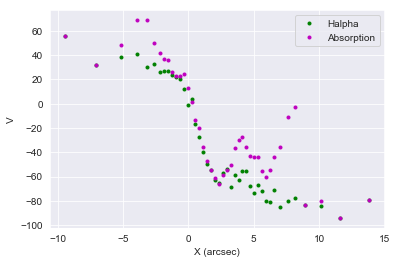

In [8]:
#a specific galaxy rotation curve
plt.plot(df[df['ID']=='23453']['#X (arcsec)'], df[df['ID']=='23453'][' V (Halpha)'], 'g.', label= 'Halpha')
plt.plot(df[df['ID']=='23453']['#X (arcsec)'], df[df['ID']=='23453'][' V (absorption)'], 'm.', label = 'Absorption')

plt.xlabel('X (arcsec)')
plt.ylabel('V')
plt.legend()

### Display missing values of the dataset in a heatmap then show the rows

[Text(0.5, 0, '#X (arcsec)'),
 Text(1.5, 0, ' V (absorption)'),
 Text(2.5, 0, ' V_err (abs)'),
 Text(3.5, 0, ' V (Halpha)'),
 Text(4.5, 0, ' V_err (H_alpha) '),
 Text(5.5, 0, 'ID')]

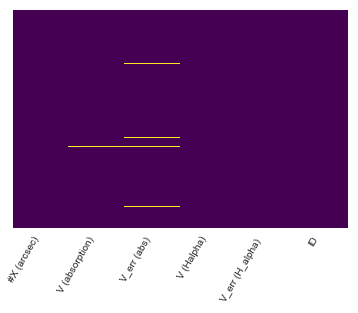

In [9]:
ax = sns.heatmap(df.isnull(),yticklabels=False, cbar=False,cmap='viridis')
ax.set_xticklabels(ax.get_xticklabels(),rotation=60, horizontalalignment='right')

In [10]:
#Show rows where there are missing data, drop error column when searching
df[df.drop([' V_err (abs)'], axis = 1).isnull().any(axis=1)]

,#X (arcsec),V (absorption),V_err (abs),V (Halpha),V_err (H_alpha),ID
4612,-8.56,NaN,6.6,-1.0,99.0,26650
4613,-7.96,NaN,3.7,-1.0,99.0,26650
4614,-7.36,NaN,3.5,-1.0,99.0,26650
4615,-6.76,NaN,4.7,-1.0,99.0,26650
5624,-15.19,NaN,NaN,-1.0,99.0,3504
5625,-14.89,NaN,NaN,-1.0,99.0,3504
8325,-5.89,NaN,13.8,-1.0,99.0,56612
8326,-5.59,NaN,7.4,-1.0,99.0,56612
8327,-5.29,NaN,6.1,-1.0,99.0,56612
8328,-4.99,NaN,3.2,-1.0,99.0,56612


### Combine files by galaxy ID to join new columns

In [11]:
#dealing with a different type of file
from astropy.io import fits
from astropy.table import Table

def table_to_python(table):
    """Convert Astropy Table to Python dict.
    Numpy arrays are converted to lists, so that
    the output is JSON serialisable.

    Can work with multi-dimensional array columns,
    by representing them as list of list.
    """
    total_data = {}
    for name in table.colnames:
        data = table[name].tolist()
        total_data[name] = data
    return total_data

In [12]:
filename = "DR23/combined_cats/combined_cat_DR2DR3.fits.gz"

table = Table.read(filename)

In [13]:
dftab = pd.DataFrame(table_to_python(table))
dftab['GASS_ID'] = dftab['GASS_ID'].apply(lambda x: str(x)) #to match with type for ID in df
#dftab.info()

dftab is the dataframe from the new file, join a few of these columns onto the previous df by the ID and GASS_ID columns. Use the groupby operation and get the first values of the new columns, since they're the same value for each galaxy ID.

In [14]:
#get the first value of stellar mass, 
mapping = dict(dftab.groupby('GASS_ID').first()['MSTAR'].reset_index().values) #could do df[[*getindex, B]] instead of reset
df['MSTAR'] = df['ID'].replace(mapping)

#obtain distance from s=theta*r distance is X_KPC/theta(deg), divide by 3600 in denominator
mapping = dict((3600*dftab.groupby('GASS_ID').first()['X_KPC']/dftab.groupby('GASS_ID').first()['X_ASEC']).reset_index().values)
df['dist'] = df['ID'].replace(mapping) 

mapping = dict(dftab.groupby('GASS_ID').first()['R50'].reset_index().values) 
df['R50'] = df['ID'].replace(mapping)

#convert from objects to strings, get x in terms of kiloparsecs distance
df[['MSTAR','dist', 'R50']] = df[['MSTAR','dist', 'R50']].apply(pd.to_numeric,errors='coerce')
df['Xkpc'] = df['#X (arcsec)'] * df['dist'] / 3600

In [15]:
# the new dataframe
df.head()

,#X (arcsec),V (absorption),V_err (abs),V (Halpha),V_err (H_alpha),ID,MSTAR,dist,R50,Xkpc
0,-9.83,172.6,99.0,-1.0,99.0,10019,10.68,2215.793242,7.19,-6.050347
1,-7.86,145.5,5.4,146.5,6.1,10019,10.68,2215.793242,7.19,-4.837815
2,-6.69,158.4,5.4,158.7,5.4,10019,10.68,2215.793242,7.19,-4.117682
3,-5.79,146.3,5.2,146.2,5.7,10019,10.68,2215.793242,7.19,-3.563734
4,-5.04,134.0,4.4,135.4,5.3,10019,10.68,2215.793242,7.19,-3.102111


### Separate into 9 mass classes and show 9 scatterplots of X(kpc)/R50 vs V (Abs)
Each galaxy will be categorized, being in one of 9 mass classes (Massbins 0-8)

In [16]:
binn= 8
Mmin = 10. #dftab['MSTAR'].min()
Mmax = 11.1 #dftab['MSTAR'].max()
binsz=(Mmax-Mmin)/float(binn) #0.35 for when I have binn = 3
binrange=  np.arange(Mmin,Mmax+0.001, binsz) #np.linspace(Mmin,Mmax, binn+1)
print(binrange, ' class boundaries \n Width of classes: ', round(binsz, 4))

def Mbin(x):
    for i in range(binn):
        if (x >= (Mmin+binsz*(i)) ) & (x < (Mmin+binsz*(i+1)) ):
            return i #could instead return median bin mass, but need to iterate
        elif (x>=Mmin+binsz*(binn)):
            return binn
df['Massbins'] = df['MSTAR'].apply(Mbin) #ID map to massbin, apply to rot curve by ID

lower = [round(binrange[i],3) for i in range(binn)]
upper = [round(binrange[i+1],3) for i in range(binn)]
binmean = 0.5*(np.array(lower)+ np.array(upper))
binmean = np.append(binmean, 11.28)

labels = ['{one} $\leq$ log M* $\leq$ {two}'.format(one=lower[i],two=upper[i]) for i in range(binn)]
labels = np.append(labels, '11.05 $\leq$ log M*')

[10.     10.1375 10.275  10.4125 10.55   10.6875 10.825  10.9625 11.1   ]  class boundaries 
 Width of classes:  0.1375


#### Also separate into 10 X distance bins

In [17]:
#remember this is for units of Xkpc, most data is less than 20
rbinn= 9
rMmin = 0 #abs(df['Xkpc']).min()
rMmax = 18 #abs(df['Xkpc']).max()# the max is too large
rbinsz = (rMmax-rMmin)/float(rbinn)
rbinrange = np.arange(rMmin,rMmax+0.001, rbinsz) 
print(rbinrange, 'class boundaries \n Width of classes: ', rbinsz)

def rMbin(x): #must use absolute values either in function or when applying to df
    for i in range(rbinn):
        if (x >= (rMmin+rbinsz*(i)) ) & (x < (rMmin+rbinsz*(i+1)) ):
            return i
    if (x >= (rMmin+rbinsz*(rbinn)) ):
        return rbinn  

df['Xbins'] = abs(df['Xkpc']).apply(rMbin) #ID map to massbin, apply to rot curve by ID

rlower = [round(rbinrange[i],3) for i in range(rbinn)]
rupper = [round(rbinrange[i+1],3) for i in range(rbinn)]
rbinmean = 0.5*(np.array(rlower)+ np.array(rupper))
rbinmean = np.append(rbinmean, 20.)

rlabels = ['{one} $\leq$ X/R50 $\leq$ {two}'.format(one=rlower[i],two=rupper[i]) for i in range(rbinn)]
rlabels = np.append(rlabels,'20 $\leq$ X/R50')

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.] class boundaries 
 Width of classes:  2.0


#### Summary of exploration of missing or bad data
    Code: df[abs(df['Xkpc'])>20]#.index     df[abs(df[' V (Halpha)'])>400]['ID'].unique()

df with index [1383, 2901, 2945, 4471, 4472, 5410, 5454, 7025, 7623] have abs x arcsec greater than 20 and vabs err is 99.

Galaxies with ID ['26650', '3504', '38758', '56612'] are greater than 400 V abs.
id '38758' has one point index 6167 where Vabs is 813.4 and nans.

The rest have nans or very high V abs consistently, with bad v halpha = -1 or very high, same for ID [ '3301', '9948']
Exclude galaxy ID ['26650', '3504', '56612'] (outlier data mixed with bad data).
Exclude points index 4471,5410,5454,7623 (outlier high x) and also 6167 (sig high V).

In [18]:
# Clean the Data
# I have indexes according to df, so do the df.drop indexes first
dfclean = df.drop([4471,5410,5454,6167,7623], axis = 0) # keep df unchanged so it doesn't redrop as I run many times
dfclean = dfclean[(dfclean['ID'] != '26650') & (dfclean['ID'] != '3504') & (dfclean['ID'] != '56612')]
ID = dfclean['ID'].unique() # won't use this to reduce size of for loop
#dftab[dftab['GASS_ID']==ID[0]]['MSTAR'] #checking that MSTAR is constant for each galaxy ID, which it is

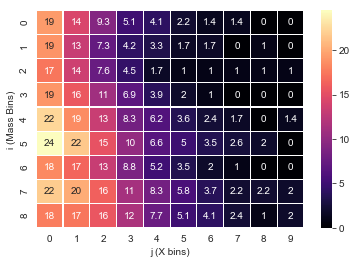

In [19]:
#show the number of galaxies that are in each mass bin, and in each X distance bin
temparr = []
for i in range(binn+1): #for each mass bin
    for j in range(rbinn+1): 
        val= len(abs(dfclean[(dfclean['Massbins']==i) & (dfclean['Xbins']==j)][' V (absorption)']))
        tarr = [i,j,np.sqrt(val)] 
        temparr.append(tarr)
testdaf=pd.DataFrame(temparr, columns=['i (Mass Bins)','j (X bins)','Vavg'])
pvdaf = testdaf.pivot_table(values='Vavg',index='i (Mass Bins)',columns='j (X bins)')

sns.heatmap(pvdaf,cmap='magma',linecolor='white', linewidth= 0.1, annot= True)
#The values shown in the pivot table are actually the square root of the counts, used to scale the colorbar better

### Scatter plots of X vs V, separated by mass bins in each subplot. 
Each color represents a different galaxy, but is not consistent across the mass bin subplots, fix and add legend

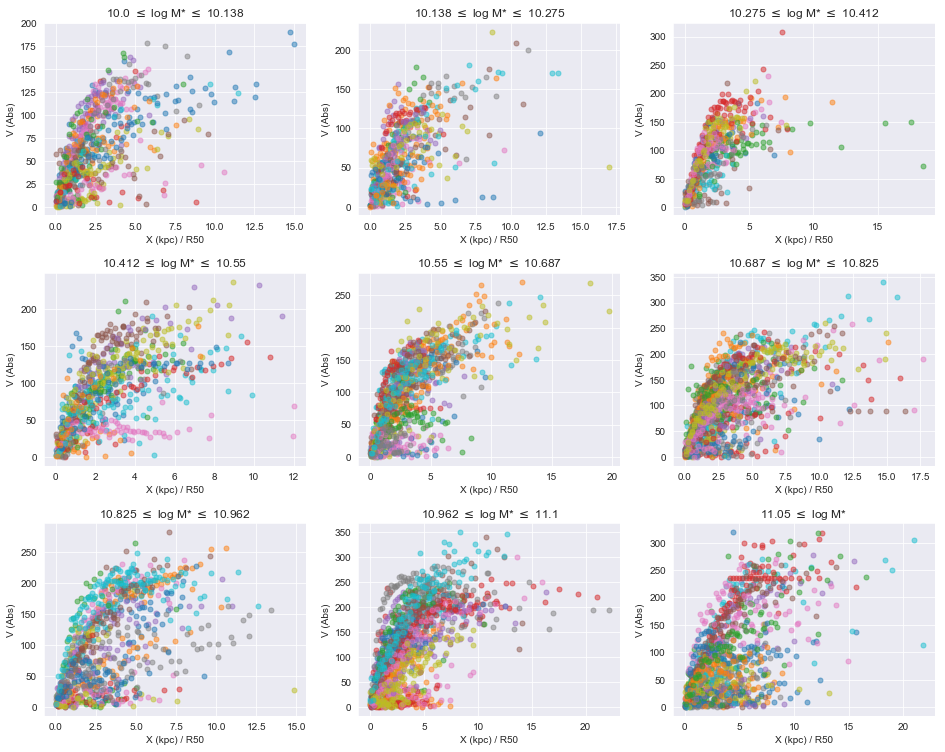

In [20]:
dflist = []

fy, axarr = plt.subplots(3, 3, figsize=(9,7))
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.5, wspace=0.2, hspace=0.3)
for i in range(9):
    dflist.append(dfclean[(dfclean['Massbins']==(i))])
    for item in dflist[i]['ID'].unique():
        tempx = abs(dflist[i][(dflist[i]['ID']==item)]['Xkpc'])#/dflist[i][(dflist[i]['ID']==item)]['R50'])
        tempy = abs(dflist[i][(dflist[i]['ID']==item)][' V (absorption)'])
        ordered = [list(x) for x in zip(*sorted(zip(tempx, tempy), key=lambda pair: pair[0]))]
        axarr[i//3,i%3].plot(ordered[0],ordered[1], '.', alpha = 0.5, markersize = 10)
        axarr[i//3,i%3].set_title(labels[i])
        axarr[i//3,i%3].set_xlabel('X (kpc) / R50')
        axarr[i//3,i%3].set_ylabel('V (Abs)')
        #axarr[i//3,i%3].axis([0,4,0,400])

In [21]:
# Which glalaxies have masses greater than 11.35
df[df['MSTAR'] >=11.35 ]['ID'].unique()

array(['28461', '40247'], dtype=object)

In [22]:
#get the average number of galaxies in each massbin
df.groupby('ID').first().groupby('Massbins').count()['dist'].mean()

25.88888888888889

### Show the distribution of X vs both types of V measurements with a scatter plot

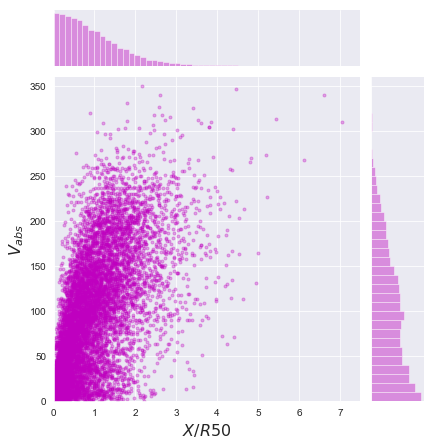

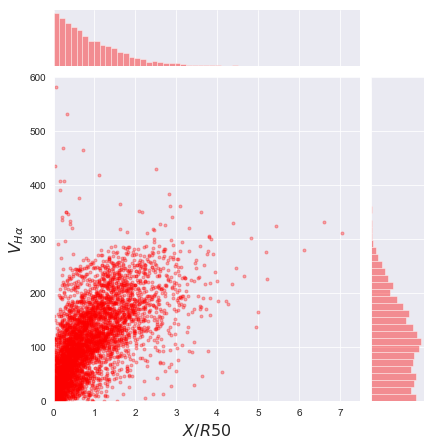

In [28]:

#Errors or missing values in V (Halpha) were set to equal -1, filter this out

x1 = abs(dfclean['#X (arcsec)'])/dfclean['R50']
x2 = abs(dfclean[dfclean[' V (Halpha)'] != -1]['#X (arcsec)'])/dfclean[dfclean[' V (Halpha)'] != -1]['R50']
y1 = abs(dfclean[' V (absorption)'])
y2 = abs(dfclean[dfclean[' V (Halpha)'] != -1][' V (Halpha)'])

h = sns.jointplot(data= dfclean, x = x1, y = y1, alpha= 0.3, color='m', marker = '.',
              kind = 'scatter', xlim = [0,7.5], ylim = [0,360], stat_func = None)
g = sns.jointplot(data= dfclean, x = x2, y = y2, alpha= 0.3, color='r', marker = '.',
              kind = 'scatter',xlim = [0,7.5], ylim = [0,600], stat_func = None)
h.set_axis_labels('$X/R50$', '$V_{abs}$', fontsize = 16)
g.set_axis_labels('$X/R50$', '$V_{H\\alpha}$', fontsize = 16)
#plt.axis([0,30, 0, 360]) #overlay plots?

In [24]:
# Show where the values of V halpha are greater than 400
dfclean[dfclean[' V (Halpha)']>400]

,#X (arcsec),V (absorption),V_err (abs),V (Halpha),V_err (H_alpha),ID,MSTAR,dist,R50,Xkpc,Massbins,Xbins
2305,5.63,88.3,27.2,464.9,16.3,13227,11.220,3407.520171,7.71,5.328983,8.0,2.0
4795,-16.19,254.6,11.3,430.1,21.4,29510,11.198,2562.527909,6.46,-11.524257,8.0,5.0
4808,-7.18,189.7,5.5,417.8,30.7,29510,11.198,2562.527909,6.46,-5.110820,8.0,2.0
5484,0.93,-51.2,2.4,407.5,44.3,3301,10.924,2875.954794,3.65,0.742955,6.0,0.0
8937,0.77,43.2,2.8,581.1,56.8,9948,10.700,1853.998866,11.00,0.396550,5.0,0.0


### Scatter plot and the distribution of X kpc and V abs, In the median mass bin of 4

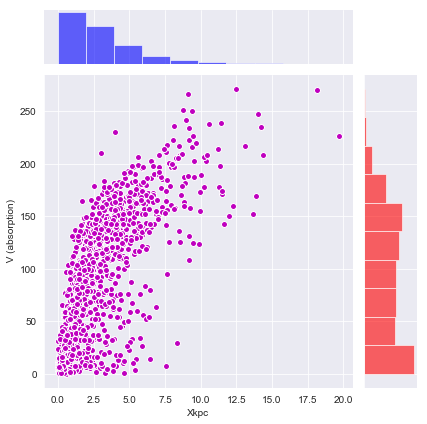

In [25]:
g = sns.JointGrid(x=abs(dfclean[dfclean['Massbins']==4]['Xkpc']), 
              y = abs(dfclean[dfclean['Massbins']==4][' V (absorption)']),data=dfclean)
g = g.plot_joint(plt.scatter, color="m", edgecolor="white")
_ = g.ax_marg_x.hist(abs(dfclean[dfclean['Massbins']==4]['Xkpc']), color="b", alpha=.6,bins=10)
_ = g.ax_marg_y.hist(abs(dfclean[dfclean['Massbins']==4][' V (absorption)']), color="r", alpha=.6, orientation="horizontal")
#, bins=np.arange(0, 20, 1))

### Fit X vs. V

In [26]:
from scipy import optimize

#this is the function that I will fit the data to
def Vper(r,V0,alpha,rpe):
    term1= (1-np.exp(-r/float(rpe)))
    term2= (1+alpha*r/float(rpe))
    return V0*term1*term2

In [27]:
import math
params =[]
for i in range(binn+1): #for each mass bin   
    curvex = []
    curvey = []
    for j in range(rbinn+1): #for each x bin
        value = abs(dfclean[(dfclean['Massbins']==i) & (dfclean['Xbins']==j)][' V (absorption)']).mean()
        if math.isnan(value) == False: 
            curvex.append(rbinmean[j])
            curvey.append(value)
    param = optimize.curve_fit(Vper, curvex, curvey)[0]
    params.append(param)
plt.plot(rbinmean, Vper(rbinmean, *params[0]), 'b.')#params[0][0],params[0][1], params[0][2])
plt.plot(rbinmean, Vper(rbinmean, *params[1]), 'r.')
plt.plot(rbinmean, Vper(rbinmean, *params[2]), 'g.')
plt.plot(rbinmean, Vper(rbinmean, *params[3]), 'k.')

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

## This is where I left off on this project, as I was obtaining the best fit curves and equations. 
I would probably try other machine learning methods if I were to continue